# Seattle Home Sales Dataset Analysis
## Alexis' Location & Home Features Analysis

This notebook is one component of Alexis and Eldrich's analysis of a Seattle home sales dataset.

I chose to focus on location data, and specifically zipcode data, as it is generally known that location is one of the most important determinants of real estate prices. This notebook differs from Eldrich's in that I take into account the location data present in the dataset, while Eldrich sought to maximize the predictive power of the home features themselves, as well as other non-continuous features present in the data (such as a home's location by the waterfront). 

In order to maximize the usefulness of this model, we both decided include the categorical home features that most people take into account when buying a home -- bedrooms, bathrooms, square footage, and number of floors, for example.

## Introduction and Business Understanding

The data contains records of about 20,000 home transactions from about 70 zip codes in the Seattle area. These sales occurred in the years 2014 and 2015. The dataset also contains information about the characteristics of the sale (e.g. price) and more granular information the house Itself (number of bedrooms, bathrooms, condition, renovation status). 

We are aiming our analysis at a new start-up, OpenDoor, which aims to buy houses from sellers via an app, renovate them (if need be), and then re-sell them, also via the app. OpenDoor has gained a lot of traction lately, as it enables sellers to close remotely (important during the Covid-19 pandemic). However, this means that quantifiable features are even more important, as in-person appraisals and walk-throughs are not conducted. With our model, we aimed to give OpenDoor a few factors that we consider to be significant predictors of sales price.

# 1. Prep and Data Exploration

In [1]:
# import all libraries required to load, transform, analyze and plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import scipy.stats as stats
import functions as fn
# set display option to remove scientific notation and 
# remove restrictions on dataframe rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)


data = pd.read_csv('data/kc_house_data.csv')

In [2]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Already, we can note the missing values for waterfront, view, and year renovated. Zipcode is an integer, which is pretty useless as zipcodes do not work numerically. Zipcode should be used as a string or category. "Date" is a datetime object, which cannot be in a model, so we will either have to transform or drop this variable. Lastly, "sqfoot_basement is an object due to the presence of a "?" in some rows. 

In [4]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","19,221.00","21,534.00","21,597.00","21,597.00","21,597.00","21,597.00","17,755.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00"
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"
std,"2,876,735,715.75","367,368.14",0.93,0.77,918.11,"41,412.64",0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,"27,274.44"
min,"1,000,102.00","78,000.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,175.00","322,000.00",3.00,1.75,"1,430.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00","1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,490.00","645,000.00",4.00,2.50,"2,550.00","10,685.00",2.00,0.00,0.00,4.00,8.00,"2,210.00","1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


* Waterfront has very few 1's, which tells us waterfront is sparsely populated 
* Small percentage of home have been renovated recently given 75th percentile 0.
* Standard deviation in price is almost $370,000.

In [5]:
not_renovated = data.loc[data['yr_renovated'] == 0]
not_renovated.head()
not_renovated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17011 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17011 non-null  int64  
 1   date           17011 non-null  object 
 2   price          17011 non-null  float64
 3   bedrooms       17011 non-null  int64  
 4   bathrooms      17011 non-null  float64
 5   sqft_living    17011 non-null  int64  
 6   sqft_lot       17011 non-null  int64  
 7   floors         17011 non-null  float64
 8   waterfront     15157 non-null  float64
 9   view           16961 non-null  float64
 10  condition      17011 non-null  int64  
 11  grade          17011 non-null  int64  
 12  sqft_above     17011 non-null  int64  
 13  sqft_basement  17011 non-null  object 
 14  yr_built       17011 non-null  int64  
 15  yr_renovated   17011 non-null  float64
 16  zipcode        17011 non-null  int64  
 17  lat            17011 non-null  float64
 18  long  

In [6]:
17011/21597
# About 78% of home have not been renovated. 

0.787655692920313

In [7]:
# From Eldrich 
df_mean_median = pd.DataFrame(data = (data.median(), data.mean()), index = ['median', 'mean'])
# Creating a df 'data_mean_median' which compares the median and mean of each column 
# in order to glimpse at skewness of each feature
df_mean_median

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
median,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"


Eldrich and I shared some preliminary analysis and sqft_lot has a significant right skew (positive skew), with the mean double that of the median. This might be due to the fact that Seattle has a lot of sprawl (with a relatively low proportion of small condos/apartments in the city center). Price has a slightly less significant postive skew, with the mean being around 120% that of the median. 

In [8]:
# Investigating outliers
data.loc[data['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,"640,000.00",33,1.75,1620,6000,1.00,0.00,0.00,5,7,1040,580.0,1947,0.00,98103,47.69,-122.33,1330,4700


In [9]:
data.loc[data['bathrooms'] == 8]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,"7,700,000.00",6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,"1,987.00",98102,47.63,-122.32,3940,8800
12764,1225069038,5/5/2014,"2,280,000.00",7,8.00,13540,307752,3.00,0.00,4.00,3,12,9410,4130.0,1999,0.00,98053,47.67,-121.99,4850,217800


In [10]:
data.loc[data['sqft_lot'] == 1651359]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,3/27/2015,"700,000.00",4,1.00,1300,1651359,1.00,0.00,3.00,4,6,1300,0.0,1920,0.00,98022,47.23,-122.02,2560,425581


In [11]:
data.loc[data['price'] == 7700000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,"7,700,000.00",6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,"1,987.00",98102,47.63,-122.32,3940,8800


After investigating some outliers, we found one outlier at 33 bedrooms - though it only sold for 640k, so it was most likely a data entry error. We also investigated the outliers in square footage and sales price. For square footage, there is an outlier at 1,651,359; the mean is nearly double the median. For sales price, a $7.7 million sale is also an outlier. 

After some thought, I have decided to remove the super cheap 33-bedroom house, but leave in outliers such as these in in order to try and avoid underfitting the model. If these are legitimate sales, as opposed to data entry errors, and we want our model to predict accurately based on all sales, it's worth leaving in some of the more interesting transactions. 

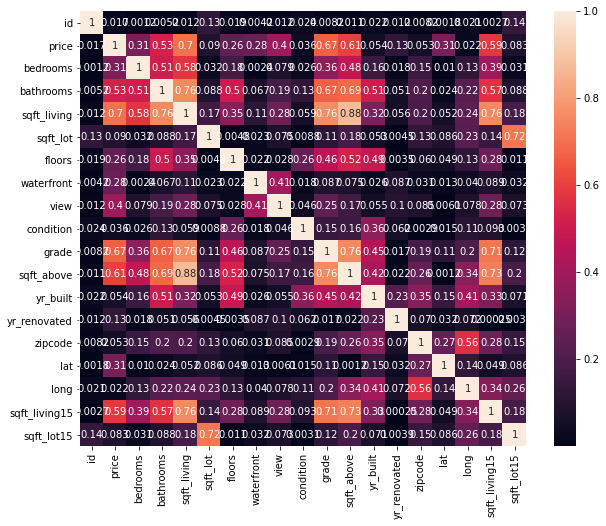

In [12]:
# IDing some initially promising coefficiencts and gauging potential multicollinearity
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().abs(), annot=True)
plt.show()

In [13]:
#Hashed out this multicollinearity pairplot as it takes a long time to load
#sns.pairplot(data)

From a super-cursory first glance, sqft_living (.70), grade (.67), sqft_above (.61), sq_ftliving15 (.59) & bathrooms (.53) seem to be relatively strong predictors. Somewhat surprisingly to me, bedrooms is not all that strong at .31, but we'll keep it in for now, because it is often a differentiating factor when buying or selling a home. In addiiton, bathrooms and sqft_living may possess a multicollinarity issue. 

# 2. Some Preliminary Visualizations

Our target for this model is sales price. It's worth exploring the distribution of home prices, as well as exploring if there are any trends for this future from year to year. 

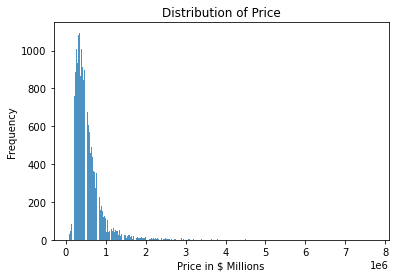

In [14]:
#From Eldrich
plt.hist(x = data.price, bins = 'auto', alpha = 0.80, rwidth= .85)
plt.xlabel('Price in $ Millions')
plt.ylabel('Frequency')
plt.title('Distribution of Price');

Eldrich shared his price distribution histogram, and it usefully depicts the slight righthand skew of price, which makes sense for an expensive urban area. Other than that, price is fairly normally distributed, with a mean of about $500,000. 

I thought it might be interesting to look at the distribution of successful home sales in different price tiers, as well as the proportion each price tier occupies in overall home sales in both 2014 and 2015.

In [15]:
# Taking a closer look at our target variable, sales price
bins=[0,100000,300000,500000,900000,2000000,7000000]
choices =['$0-$100k','$100k-$300k','$400k-$500k','$600k-$900k','$1mlln-$2mlln','$2mlln-$7mlln']
data['price_range']=pd.cut(data['price'],bins=bins,labels=choices)

In [16]:
#Convert "date" column into datetime format
data['date']= pd.to_datetime(data['date'])
# Grab year from date column
data['year_of_sale'] = pd.DatetimeIndex(data['date']).year
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_range,year_of_sale
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650,$100k-$300k,2014
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639,$600k-$900k,2014
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062,$100k-$300k,2015
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000,$600k-$900k,2014
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503,$600k-$900k,2015


In [17]:
data['year_of_sale'].value_counts()

2014    14622
2015     6975
Name: year_of_sale, dtype: int64

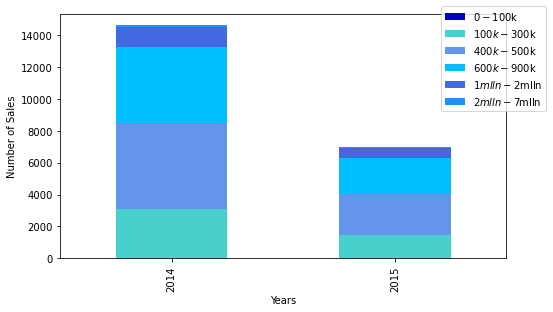

In [18]:
plt.rcParams["figure.figsize"] = [8,4.5]
ax = data.groupby(['year_of_sale','price_range']).size().unstack().plot.bar(stacked=True, color=['mediumblue','mediumturquoise','cornflowerblue','deepskyblue','royalblue','dodgerblue'])
horiz_offset = 1
vert_offset = 1
ax.set_xlabel('Years')
ax.set_ylabel('Number of Sales')
ax.legend(bbox_to_anchor=(1.1, 1.05));

We can see that the supply of homes (i.e. number of sales) decreased by almost half from 2014 to 2015. However, the proportion of homes sold within each price range has remained relatively constant from year to year despite the decrease in total overall sales; this stability may be helpful for teasing out strong features for the particularly high-value homes. 

In [19]:
def conv(year):
  return data[data['year_of_sale']==year].groupby('price_range').size()
perc_total = [x/sum(x)*100 for x in [conv(2014),conv(2015)]]
year_names = list(range(2014,2016))
housing_df = pd.DataFrame(perc_total, index= year_names)

Function courtesy of [Emmanuel Sibanda](https://hackernoon.com/predicting-the-price-of-houses-in-brooklyn-using-python-1abd7997083b)

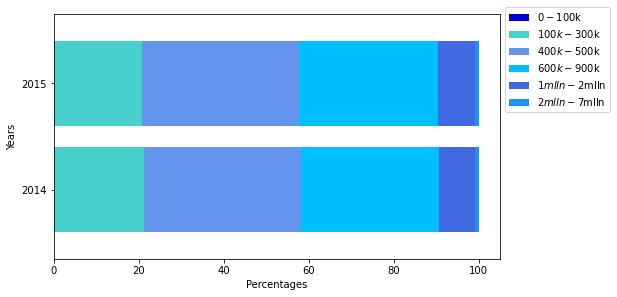

In [20]:
plt.rcParams["figure.figsize"] = [8,4.5]
ax_two = housing_df.plot(kind='barh', stacked=True, color=['mediumblue','mediumturquoise','cornflowerblue','deepskyblue','royalblue','dodgerblue'], width=0.8)
horiz_offset = 1
vert_offset = 1
ax_two.set_xlabel('Percentages')
ax_two.set_ylabel('Years')
ax_two.legend(bbox_to_anchor=(1.0, 1.05));

We can see that most homes sold are within the mid-price $400,000 - $500,000 range, with a sizeable chunk in the $600,000-$900,000 range. The proportion each price tier occupies in overall total home sales does not change much from year to year. This could be good news for trying to predict future sales prices, as the proportion each tier occupies in the housing market looks like it remains relatively stable from year to year -- granted, we have only two years' worth of data. 

# 3. Data Cleaning

In [21]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_range,year_of_sale
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650,$100k-$300k,2014
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639,$600k-$900k,2014
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062,$100k-$300k,2015
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000,$600k-$900k,2014
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503,$600k-$900k,2015


Eldrich is focusing on the categorical variables that lend themselves to boolean values, like waterfront, view, and yr_renovated, so I'm dropping those from my model. I also have a strategy in mind to deal with zipcodes as an indicator of location, rather than lat-long, so I'm dropping the latter columns for now (though this would be an interesting analysis if I have the time). 

After examining the heatmap above, I realized that I wanted to minimize dimensionality, and prioritize the variables that are already readily available and discussed when purchasing homes - such as interior square footage, bedrooms, bathrooms, and floors. My thought is, these things are oft-talked about for a reason! For our business model, it makes sense to use variables that OpenDoor probably already has on hand and that are generally known to be important to homebuyers. I feel like unless you're buying a farm, people are more concerned about the square footage of the house itself rather than the lot size. If my model performs poorly, however, I can of course re-evalute and add in the columns that I initially eliminated. 

This rationale led me to eliminate "sqft_above" and "sqft_basement" as these may be encapsulated in the square footage feature of a house. I kept in lot square footage, because I was interested in seeing how lot size performs. However, I  eliminated sqft_lot_15 - the square footage of the homes of the nearest 15 neighbors. Since I am prioritizing zip code for location data, and the interior square footage over lot square footage, two lot variables didn't seem necessary for my preliminary model. If lot square footage is a sleeper that does well later on, I can always add lot_sqft_15 back in. 

Other than that, I decided to drop some columns that are unnecessary for my focus on house-feature and location values, like id and date, and the columns I built for my visualizations above, "price range" and "year of sale." 

In [22]:
# Dropping some unneeded columns, and those that looked less promising based on my initial heatmap, above. 
# df.drop(['B', 'C'], axis=1, inplace=True)f
to_drop = ['id', 'date', 'view', 'sqft_above', 'lat', 'long', 'sqft_lot15', 'sqft_basement', 'waterfront','yr_renovated', 'price_range', 'year_of_sale']

In [23]:
data.drop(to_drop, axis = 1, inplace = True)

In [24]:
data.shape

(21597, 11)

In [25]:
# Drop one really obvious outlier that was clearly a data entry error
mask = data.loc[data['bedrooms']>20].index
data.drop(mask, axis = 0, inplace=True)

In [26]:
data.shape

(21596, 11)

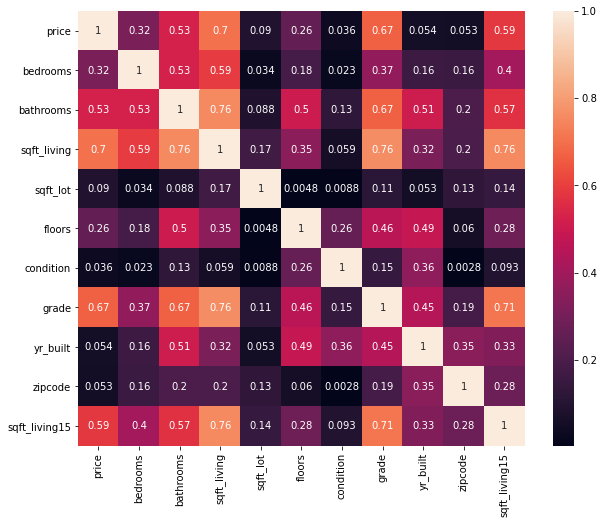

In [27]:
#Doesn't hurt to look at a revised heatmap of my trimmed-down dataset. 
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().abs(), annot=True)
plt.show()

In [28]:
#Hashed out because this takes a while to load. 
#sns.pairplot(data)

Already, we can see that the two square footage variables (sqft_living and sqft_living_15) appear to be strongly correlated with sales price. In addition, grade seems to be a significant predictor of price. Importantly, there might be some potential multicollinearity issues amongst these three variables. I'm going to run a FSM and see what we're working with first.

# 3. Split Data into Training and Test Sets

It's easier to split our data now along a random seed rather than doing it each time for each model that follows. Eldrich and I used the same random seed so that we can compare models. 

In [29]:
# divide dataset into X predictors and y target
X = data.drop(['price'], axis=1)
y = data[['price']]

# split data 80% training and 20% test w/ random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [30]:
len(X_test) + len(X_train) == len(X)

True

In [31]:
X_train.shape

(17276, 10)

In [32]:
X_test.shape

(4320, 10)

I'm using a standard scaler to scale our continuous variables (the square footage columns). There should be no change in our categorical variables and these columns should look the same.

In [33]:
# Instantiate a scaler
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()

In [35]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. First Substandard Model

In [36]:
# Instantiate a linear regression model
lr = LinearRegression()

In [37]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error

In [39]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.6237661706892493
Mean Absolute Error: 144945.57636353228
---
Testing Scores:
R2: 0.6052645946329722
Mean Absolute Error: 145254.48398036984


This is an OK return for our first substandard model (though the coefficient of determination means that our model is only accounting for between 60% - 62% of the variance in our data). Our training r-square is higher than that of our testing, which is an indication of underfitting. Our MAE, which indicates the average error in predicting home price, is $145,254. This is almost 2x more than the minimum home sale price in our dataset -- a substantial amount of error.

Let's see what happens when we transform zip codes into something that will be actually useful in predicting our sales price. Right now, our zip codes are simply empty codes that tell our model nothing about their value relative to each other. 

# 5. Model 1 (Zip Code Engineering)

To engineer a location feature, I chose to use the median price for each individual zip code. Zip code is a categorical feature, which is oftentimes dealt with through one-hot encoding. However, given the many unique zip codes present in the dataset (70), I was concerned that adding 70 additional variables to my dataset would increase the dimensionality to a point that decreases the reliability of the model. 

Therefore, using the median price for each zip code seemed like an appropriate proxy and could be a reasonably good predictor of future home prices for that area. 

In [40]:
# Making a copy of my training and testing data so that I have something to work with for my second model
traindf = X_train.copy()

In [41]:
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550


In [42]:
traindf['price'] = y_train

In [43]:
traindf.shape

(17276, 11)

In [44]:
testdf = X_test.copy()

In [45]:
testdf['price'] = y_test

In [46]:
testdf.shape

(4320, 11)

My strategy will be to replace all values in zipcode column with median sale price. I will group all zipcodes together with median average sale price, and replace any zipcode value with its median average sales price. This will give my model some context about the potential values of each home based on its location within the Seattle area. 

This is an imperfect strategy - another method would be to map zip codes and aggregate based on neighborhood, as people often refer to neighborhood, rather than zip codes, when discussing real estate. However, I have limited knowledge of the Seattle area and doing this sort of mapping would take some time - but it would be interesting to see how a neighborhood-based model compares to a zip-code based model. For our business scenario, let's assume that OpenDoor collects both zip code and neighborhood data on potential purposes and that either would be valuable to them.

In [47]:
#Creating a new dataframe that aggregates by zip code
zip_group = traindf.groupby(['zipcode']).median()

In [48]:
#Doing same for testing data
test_zip_group = testdf.groupby(['zipcode']).median()

In [49]:
zip_group.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price
zipcode,,,,,,,,,,
98001,3.00,2.12,"1,875.00","9,303.50",1.00,3.00,7.00,"1,981.00","1,710.00","264,750.00"
98002,3.00,1.75,"1,575.00","7,279.00",1.00,4.00,7.00,"1,967.00","1,420.00","235,000.00"
98003,3.00,2.00,"1,730.00","8,900.00",1.00,3.00,7.00,"1,975.00","1,755.00","265,000.00"
98004,4.00,2.50,"2,620.00","11,125.00",1.00,3.00,8.00,"1,964.00","2,510.00","1,100,000.00"
98005,4.00,2.25,"2,500.00","12,815.50",1.00,4.00,8.00,"1,967.00","2,490.00","779,000.00"


In [50]:
#Looks like we have about 70 unique zip codes
zip_group.shape

(70, 10)

In [51]:
#Creating a referential dataframe from our training data that matches median price per zip code to zip code
zip_group = zip_group['price'].reset_index()

In [52]:
zip_group.head()

,zipcode,price
0,98001,"264,750.00"
1,98002,"235,000.00"
2,98003,"265,000.00"
3,98004,"1,100,000.00"
4,98005,"779,000.00"


In [53]:
# Join zip_group with train df
joined_zip = pd.merge(zip_group, traindf, how = 'inner', on='zipcode').reset_index()
joined_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [54]:
# Join zip_group with test df 
joined_test_zip = pd.merge(zip_group, testdf, how='inner', on='zipcode').reset_index()
joined_test_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,1,98001,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,2,98001,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,3,98001,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,4,98001,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [55]:
joined_test_zip.shape

(4320, 13)

##  Visualizing Median Price per Zip Code

Before running a regression, it might be useful to visualize the median price per zip code. I did this by sourcing some location data from the King County GIS Database (King County contains the Seattle metro area). Then, I overlayed this geojson file on a folium map of Seattle, then used my referential dataframe above to tag each geographic zip code with its zipcode label and median sales price.

In [56]:
import folium
import json
import geopandas as gpd
import branca.colormap as cm
#from shapely.geometry import shape

[Link to geojson file](https://www5.kingcounty.gov/sdc/Metadata.aspx?Layer=zipcode) from King County GIS Database

In [57]:
# Load GeoJSON
with open('data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson', 'r') as jsonSea:
    jsdata = json.load(jsonSea)
tmp = jsdata

In [58]:
# Load fresh version of original data to grab zipcodes 
orig_df = pd.read_csv('data/kc_house_data.csv')

In [59]:
zip_group.shape

(70, 2)

In [60]:
zipcodes_indf = []

for x in orig_df['zipcode']:
    if x not in zipcodes_indf:
        zipcodes_indf.append(x)

In [61]:
len(zipcodes_indf)

70

This method of cleaning the JSON and saving it as a new file is courtesy of [Jonny Hofmeister](https://github.com/jonnyhof). Thanks, Jonny! 

In [62]:
# Parse the GeoJSON for zipcodes that are in our dataset. 
geozips = []

for i in range(len(tmp['features'])):
    if int(tmp['features'][i]['properties']['ZIPCODE']) in zipcodes_indf:
        geozips.append(tmp['features'][i])

In [63]:
len(geozips)

74

In [64]:
# We have four duplicate zipcodes. 
zips = []
for i in geozips:
    zips.append(i['properties']['ZIPCODE'])

In [65]:
# Use pandas to easily find duplicates. 
zips = pd.DataFrame(zips)
zips.value_counts().head()

98072    2
98077    2
98092    2
98022    2
98199    1
dtype: int64

In [66]:
# Find index of duplicates to remove them. 
for i in geozips:
    if i['properties']['ZIPCODE'] in ['98072', '98077', '98092', '98022']:
        print(str(geozips.index(i))+' is an index of '+i['properties']['ZIPCODE'])

13 is an index of 98022
14 is an index of 98022
25 is an index of 98092
41 is an index of 98072
42 is an index of 98072
46 is an index of 98077
47 is an index of 98077
48 is an index of 98092


In [67]:
# Make list of indices to remove them. 
to_del = [14, 41, 46, 48]
for d in to_del: 
    del geozips[d]

In [68]:
# Sanity check
len(geozips)

70

In [69]:
# Creating a new JSON object
new_json = dict.fromkeys(['type', 'features', 'zipcode'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

In [70]:
# Same GeoJSON object as an updated file. 

open('data/updated-file.json', 'w').write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

11110915

In [71]:
# Read in cleaned GeoJSON file as a Geopandas dataframe 
loc_data = gpd.read_file('data/updated-file.json')
loc_data.head()

,COUNTY,OBJECTID,Shape_Area,Shape_Length,ZIP,ZIPCODE,ZIP_TYPE,geometry
0,033,1,"228,012,907.12","117,508.23",98031,98031,Standard,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,033,2,"482,675,358.83","166,737.67",98032,98032,Standard,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,033,3,"200,095,361.22","94,409.54",98030,98030,Standard,"POLYGON ((-122.21006 47.38692, -122.21060 47.3..."
3,033,4,"277,424,676.85","111,093.72",98029,98029,Standard,"POLYGON ((-121.97642 47.58430, -121.97640 47.5..."
4,033,5,"199,653,136.52","71,488.23",98028,98028,Standard,"POLYGON ((-122.22788 47.76909, -122.22777 47.7..."


In [72]:
#All we need from the GeoJSON is the location data tied to zipcode, so drop all other columns
geos = loc_data[['ZIPCODE' , 'geometry']]
geos.head()

,ZIPCODE,geometry
0,98031,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,98032,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,98030,"POLYGON ((-122.21006 47.38692, -122.21060 47.3..."
3,98029,"POLYGON ((-121.97642 47.58430, -121.97640 47.5..."
4,98028,"POLYGON ((-122.22788 47.76909, -122.22777 47.7..."


In [73]:
# Change zipcode colum in zipcodes/price df to str so it can key on the json zipcode column
zip_group['zipcode'] = zip_group['zipcode'].astype(str)

In [74]:
geos.dtypes

ZIPCODE       object
geometry    geometry
dtype: object

In [75]:
zip_group.dtypes

zipcode     object
price      float64
dtype: object

In [76]:
# Join zipcode/median price df with geos df (that has location data) 
geos = geos.merge(zip_group, left_on = 'ZIPCODE', right_on='zipcode', how='inner')
geos.head()

,ZIPCODE,geometry,zipcode,price
0,98031,"POLYGON ((-122.21842 47.43750, -122.21896 47.4...",98031,"289,950.00"
1,98032,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436...",98032,"250,000.00"
2,98030,"POLYGON ((-122.21006 47.38692, -122.21060 47.3...",98030,"285,000.00"
3,98029,"POLYGON ((-121.97642 47.58430, -121.97640 47.5...",98029,"572,750.00"
4,98028,"POLYGON ((-122.22788 47.76909, -122.22777 47.7...",98028,"446,000.00"


In [77]:
geos.drop(['zipcode'],axis = 1, inplace=True)

In [78]:
geos.head()

,ZIPCODE,geometry,price
0,98031,"POLYGON ((-122.21842 47.43750, -122.21896 47.4...","289,950.00"
1,98032,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436...","250,000.00"
2,98030,"POLYGON ((-122.21006 47.38692, -122.21060 47.3...","285,000.00"
3,98029,"POLYGON ((-121.97642 47.58430, -121.97640 47.5...","572,750.00"
4,98028,"POLYGON ((-122.22788 47.76909, -122.22777 47.7...","446,000.00"


In [79]:
# Visualize relationship between zip code and median house price 

# Initiate folium map 
Seattle_map = folium.Map(location = [47.608013,-122.335167], zoom_start = 10)

# Change map to grayed-out version 
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(Seattle_map)

# Create colormap 
colormap = cm.linear.YlGnBu_09.to_step(data=geos['price'], method='quant', quantiles=[0,0.1,0.75,0.9,0.98,1])
colormap

# Creating a choropleth map 
folium.Choropleth(
            geo_data = geos,
            fill_opacity = 0.7,
            line_opacity = 0.2,
            data = geos,
            #refers to which key within json file to map zip to
            key_on = 'feature.properties.ZIPCODE',
            # first element is location, second element is price
            columns = ['ZIPCODE', 'price'],
            # change the colormap to whatever you want, the diverging maps work well for price
            fill_color = 'YlGnBu',
            legend_name = 'Price'
).add_to(Seattle_map)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

NIL = folium.features.GeoJson(
    data = geos,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['ZIPCODE', 'price'],
        aliases=['Zipcode', 'Median Price'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
Seattle_map.add_child(NIL)
Seattle_map.keep_in_front(NIL)

folium.LayerControl().add_to(Seattle_map)
#Seattle_map.save('data/zipcode_price_map.html')

#Seattle_map

In [80]:
from IPython.display import IFrame

IFrame(src='data/zipcode_price_map.html', width=950, height=600)

## Back to Modeling

In [81]:
# Joined_zip is the training data for iteration 2
joined_zip.shape

(17276, 13)

In [82]:
joined_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [83]:
# Rename price_x column as median price per zipcode 
joined_zip = joined_zip.rename(columns={"price_x": "med_price_for_zip"})
joined_zip.head()

,index,zipcode,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [84]:
# Drop zipcode and index columns
trained_zip = joined_zip.drop(['index', 'zipcode'], axis=1)
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [85]:
# Do the same with test data
test_zip = joined_test_zip.rename(columns={"price_x": "med_price_for_zip"})
test_zip.head()

,index,zipcode,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,1,98001,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,2,98001,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,3,98001,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,4,98001,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [86]:
test_zip = joined_test_zip.drop(['index', 'zipcode'], axis=1)
test_zip.head()

,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [87]:
# Divide data in to x predictors and y targets 
X_test_zip = test_zip.drop(['price_y'], axis=1)
y_test_zip = test_zip[['price_y']]

X_trained_zip = trained_zip.drop(['price_y'], axis=1)
y_trained_zip = trained_zip[['price_y']]

In [88]:
# Train our scaler on training data, then fit to testing
X_trained_zip_scaled = scaler.fit_transform(X_trained_zip)
X_test_zip_scaled = scaler.transform(X_test_zip)

In [89]:
# Fit our model on our scaled data
lr.fit(X_trained_zip_scaled, y_trained_zip)

LinearRegression()

In [90]:
# Evaluate
y_train_pred = lr.predict(X_trained_zip_scaled)
y_test_pred = lr.predict(X_test_zip_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_trained_zip, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_trained_zip, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test_zip, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_zip, y_test_pred)}")

Training Scores:
R2: 0.7363291865117058
Mean Absolute Error: 112465.36617955659
---
Testing Scores:
R2: 0.7229711101210686
Mean Absolute Error: 111841.20169660255


Just feeding our model some meaningful location data had a big impact on our coefficient of determination. Our model is now accounting for between 72-73% of the variance in our data. Though we underfit our first model, our training now higher than testing, which is an indication of slight overfitting. Our Mean Absolute Error went down slightly, and is now a little less than half of one standard deivation, hovering around $112,000. Obviously, this is still a big difference for the home seller who may be paying off a loan when they sell to OpenDoor. It certainly would make me gulp. We want to try and lower this error as much as possible.

# 6. Checking Some Assumptions

Before moving on, I want to check my assumptions using a pairplot to check for multicollinearity. I'll also use a couple of new methods to verify multicollinearity and check for normality in my data.

In [91]:
# Check for linearity and multicollinearity with sns pairplot
# This is hashed out for now, it takes a long time to load. 
#sns.pairplot(trained_zip)

Thankfully, there don't appear to be any extreme (i.e. a straight line) instances of multicollinearity in my data. However, some variables seem to be linearly related - the two interior square footage variables and bathrooms, weirdly. I guess the bigger your house, the bigger your bathrooms? 

In [92]:
trained_zip.corr()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
med_price_for_zip,1.00,0.12,0.24,0.31,-0.03,0.15,0.04,0.38,-0.04,0.35,0.64
bedrooms,0.12,1.00,0.53,0.59,0.04,0.18,0.02,0.36,0.16,0.40,0.32
bathrooms,0.24,0.53,1.00,0.76,0.08,0.50,-0.13,0.66,0.50,0.57,0.53
sqft_living,0.31,0.59,0.76,1.00,0.17,0.35,-0.06,0.76,0.31,0.76,0.70
sqft_lot,-0.03,0.04,0.08,0.17,1.00,-0.01,-0.01,0.11,0.05,0.15,0.09
floors,0.15,0.18,0.50,0.35,-0.01,1.00,-0.26,0.46,0.48,0.28,0.26
condition,0.04,0.02,-0.13,-0.06,-0.01,-0.26,1.00,-0.14,-0.36,-0.09,0.04
grade,0.38,0.36,0.66,0.76,0.11,0.46,-0.14,1.00,0.44,0.72,0.67
yr_built,-0.04,0.16,0.50,0.31,0.05,0.48,-0.36,0.44,1.00,0.33,0.05
sqft_living15,0.35,0.40,0.57,0.76,0.15,0.28,-0.09,0.72,0.33,1.00,0.59


Indeed, the two square footage variables are closely related to each other, which is to be expected. Big houses are usually clustered near other big houses. We might want to do something about the square footage/bathroom issue. 

In addition, in the pursuit of discerning feature selection and reducing dimensionality, we could probably drop some columns that aren't doing as much for the model - year built and condition, for example.

Before I mess around with any features, I weant to check my residuals using a scatterplot. 

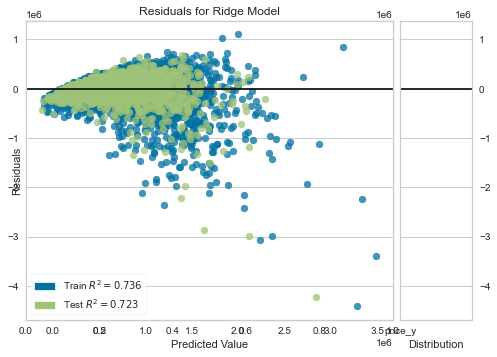

In [93]:
# Checking for last 3 linear assumptions - 
# errors are normally distributed, errors are homoskedastic, errors are not correlated
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

model = Ridge()
visualizer = ResidualsPlot(model)

visualizer = ResidualsPlot(model, hist=True, qqplot=False)
visualizer.fit(X_trained_zip_scaled, y_trained_zip)  # Fit the training data to the visualizer
visualizer.score(X_test_zip_scaled, y_test_zip)  # Evaluate the model on the test data
visualizer.show();# Finalize and render the figure

I could have checked for normality and logged any non-normal distributions at the outset of my model, but I wanted to see how my model would perform through simply giving it some meaningful location data. Now, however, we can avoid it no longer - my errors aren't very normally distributed and are skewed slightly negative. In addition, there is some obvious heteroskedasticity with the cone-shaped pattern in the residuals plot. 

This is most obviously fixed through log-transforming data. I was concerned about the relevance that log-transformed values would have for my stakeholder (logged dollar amounts won't mean much), but thankfully Lindsey came through with a function that helps us see the logged data in meaningful units after we are through with the regression.

# 7. Model 2 (Log-Transform)

In [94]:
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [95]:
trained_zip.astype('int64').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17276 entries, 0 to 17275
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   med_price_for_zip  17276 non-null  int64
 1   bedrooms           17276 non-null  int64
 2   bathrooms          17276 non-null  int64
 3   sqft_living        17276 non-null  int64
 4   sqft_lot           17276 non-null  int64
 5   floors             17276 non-null  int64
 6   condition          17276 non-null  int64
 7   grade              17276 non-null  int64
 8   yr_built           17276 non-null  int64
 9   sqft_living15      17276 non-null  int64
 10  price_y            17276 non-null  int64
dtypes: int64(11)
memory usage: 1.4 MB


In [96]:
# Transforming non-normal features 
non_normal = ['med_price_for_zip', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','condition', 'yr_built', 'sqft_living15', 'price_y']

In [97]:
for feat in non_normal:
    trained_zip[feat] = trained_zip[feat].map(lambda x: np.log(x))
#pd.plotting.scatter_matrix(x_cols, figsize=(10,12));

In [98]:
# Checking for infinity values
ds = trained_zip.isin([np.inf, -np.inf]).values.sum()
print(ds)

0


In [99]:
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,12.49,0.69,0.56,7.11,9.66,0.00,1.10,6,7.59,7.32,12.28
1,12.49,1.39,0.92,7.78,8.43,0.69,1.10,8,7.60,7.71,12.54
2,12.49,1.61,0.56,7.58,9.07,0.00,1.10,7,7.58,7.41,12.52
3,12.49,1.10,0.00,7.24,9.68,0.00,1.39,6,7.58,7.26,12.35
4,12.49,1.39,0.56,7.49,9.39,0.00,1.61,6,7.57,7.35,12.21


In [100]:
non_normal_test = ['price_x', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','condition', 'yr_built', 'sqft_living15', 'price_y']

In [101]:
for feat in non_normal_test:
    test_zip[feat] = test_zip[feat].map(lambda x: np.log(x))
#pd.plotting.scatter_matrix(x_cols_test, figsize=(10,12));

In [102]:
test_zip.head()

,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,12.49,1.10,0.56,7.68,9.21,0.00,1.39,7,7.59,7.63,12.47
1,12.49,1.10,0.00,7.05,8.78,0.41,1.39,5,7.57,7.00,12.05
2,12.49,1.10,0.69,6.96,9.81,0.00,1.39,7,7.58,7.43,12.43
3,12.49,1.61,0.92,7.79,8.87,0.69,1.10,8,7.60,7.48,12.51
4,12.49,1.10,0.81,7.51,9.34,0.00,1.10,7,7.58,7.71,12.35


In [103]:
# Divide data in to x predictors and y targets 
X_test_2 = test_zip.drop(['price_y'], axis=1)
y_test_2 = test_zip[['price_y']]

X_train_2 = trained_zip.drop(['price_y'], axis=1)
y_train_2 = trained_zip[['price_y']]

In [104]:
# Train our scaler on training data, then fit to testing
X_train_2_scaled = scaler.fit_transform(X_train_2)
X_test_2_scaled = scaler.transform(X_test_2)

In [105]:
# Fit our model on our scaled data
lr.fit(X_train_2_scaled, y_train_2)

LinearRegression()

In [106]:
y_train_2_pred = lr.predict(X_train_2_scaled)
y_test_2_pred = lr.predict(X_test_2_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train_2, y_train_2_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_2, y_train_2_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test_2, y_test_2_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_2, y_test_2_pred)}")

Training Scores:
R2: 0.82671349418667
Mean Absolute Error: 0.1645997033759281
---
Testing Scores:
R2: 0.8227638239724818
Mean Absolute Error: 0.16450586856045463


In [107]:
#now to print MAE in terms of $$ and not logged price, function provided by Lindsey and is imported from py file
fn.print_metrics(y_train_2, y_train_2_pred, y_test_2, y_test_2_pred, log=True)

Training Scores
----------
R2: 0.8267
RMSE: 174228.1287
MAE: 94313.9688

**********
Testing Scores
----------
R2: 0.8228
RMSE: 180291.1385
MAE: 93459.3011


After the log-transform, our model is now accounting for between 82-83% of the variance in our data, though we still have some slight overfitting happening. Our Mean Absolute Error continues to decrease and is now hovering around $94,000. Still a big chunk of change -- it would be worth exploring ways to get this error down. 

Before proceeding, I thought it would be a good idea to check our coefficients and p-values for all of our variables using an OLS function.

In [108]:
model_two = sm.OLS(y_train_2, sm.add_constant(X_train_2_scaled)).fit()

model_two.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     8237.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        10:09:00   Log-Likelihood:                 1675.7
No. Observations:               17276   AIC:                            -3329.
Df Residuals:                   17265   BIC:                            -3244.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0493      0.002   7807.837      0.000      13.046      13.053
x1             0.2553      0.002    131.703      0.000       0.251       0.259
x2            -0.0313      0.002    -13.799      0.000      -0.036      -0.027
x3             0.0345      0.003     11.414      0.000       0.029       0.040
x4             0.1803      0.004     45.630      0.000       0.173       0.188
x5            -0.0024      0.002     -1.196      0.232      -0.006       0.002
x6             0.0183      0.002      8.287      0.000       0.014       0.023
x7             0.0201      0.002     11.114      0.000       0.017       0.024
x8             0.1536      0.003     52.391      0.000       0.148       0.159
x9            -0.1018      0.002    -44.771      0.000      -0.106      -0.097
x10            0.0235      0.003      8.447      0.000       0.018       0.029
==============================================================================
Omnibus:                     1192.549   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3699.195
Skew:                           0.342   Prob(JB):                         0.00
Kurtosis:                       5.161   Cond. No.                         5.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-values for all but one of the predictors (sqft_lot) seem to be significant. Could my initial hypothesis about people not caring about lot size be accurate? 

The Root Mean Squared Error is about half of the standard deviation, while the Mean Absolute Error is about a quarter of the standard deviation (lower than what it was in the first model, but still a substantial amount of error in the context of home prices). 

# 8. Checking Assumptions, Again

Before moving to the final version of our model, let's check back in with the residuals plot: 

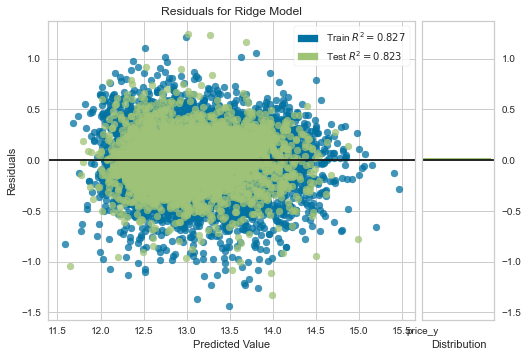

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [109]:
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_2_scaled, y_train_2)  # Fit the training data to the visualizer
visualizer.score(X_test_2_scaled, y_test_2)  # Evaluate the model on the test data
visualizer.show()           

Residuals still seems to be much more normally distributed around zero, and homoskedastic, with a much more symmetrical shape.

I want to check for multicollinearity one more time using a heatmap and pairplot. 

In [136]:
# Turning traning data back into a dataframe so that it works with matplotlib.
X_train_2_scaled = pd.DataFrame(X_train_2_scaled, columns = ['price_x', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'condition', 'grade', 'yr_built', 'sqft_living15'])

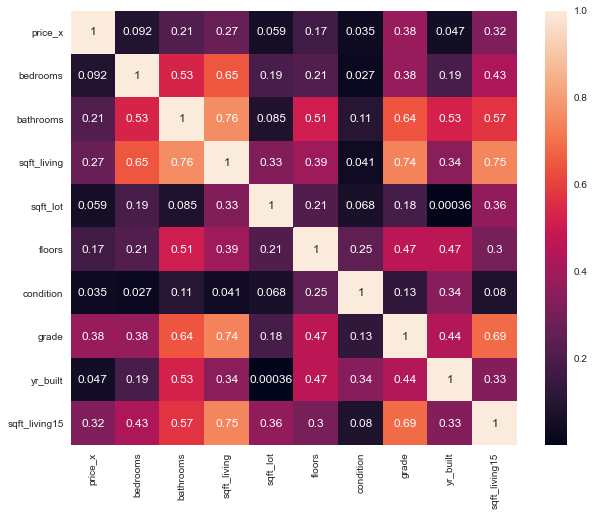

In [111]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_2_scaled.corr().abs(), annot=True)
plt.show()

Still getting some multicollinearity issues with square footage features and bathrooms (still weird! Do rich people just really like huge showers? Why not huge bedrooms?). Sqft_living and bathroms may be multicollinear at .76, sqft_living and sqft_living15 may be multicollinear at .75. Sqft_living and grade may be multicollinear at .74

In the interest of seaborn running quickly, I will focus the multicollinearity check for the variables I flagged above. 

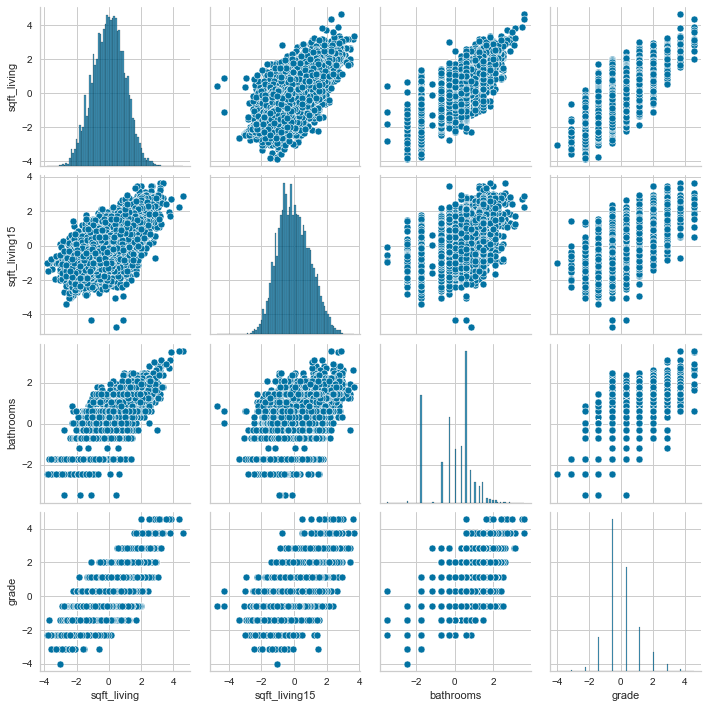

In [137]:
sns.pairplot(
    X_train_2_scaled,
    x_vars=["sqft_living", "sqft_living15", "bathrooms","grade"],
    y_vars=["sqft_living", "sqft_living15", "bathrooms","grade"],
);

None of these appear to be extreme cases of multicollinearity; however, there is evidence of linear relationships amongst many of these variables. Interestingly, grade and sqft_living seem to have a positive linear correlation. In addition, sqft_living and sqft_living 15 appear to have higher multicollinearity relative to the rest of the variables in these plots. 

# 9. Model 3 (Add combined square footage feature) 

For this project, we have changed only one element at a time so that the effects on the model can be easily tracked. Though there are several potential multicollinear relationships above, one of the easiest things to try and mitigate woul be the sqft_living and the sqft_living15 multicollinearity issue. It makes sense that a home's square footage would be closely related to the square footage of a home's neighbors, especially as you get either closer to and farther away from the Seattle city center. We can turn this column into a ratio (house size/neighbor size or "sqft_ratio") that could tell us about the size of a property relative to nearby properties. A ratio of more than 1 would tell us that the property is larger than those of the nearest 15 neighbors, while a value of less than 1 would indicate that the property is smaller than the surrounding homes. This is also valuable because it'll give our model additional info that can reflect a home's location.

In [113]:
# Adding new column to training data from Model 2 
trained_zip['sqft_living_ratio'] = trained_zip['sqft_living']/trained_zip['sqft_living15']

In [114]:
model_3_train = trained_zip
model_3_train.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y,sqft_living_ratio
0,12.49,0.69,0.56,7.11,9.66,0.00,1.10,6,7.59,7.32,12.28,0.97
1,12.49,1.39,0.92,7.78,8.43,0.69,1.10,8,7.60,7.71,12.54,1.01
2,12.49,1.61,0.56,7.58,9.07,0.00,1.10,7,7.58,7.41,12.52,1.02
3,12.49,1.10,0.00,7.24,9.68,0.00,1.39,6,7.58,7.26,12.35,1.00
4,12.49,1.39,0.56,7.49,9.39,0.00,1.61,6,7.57,7.35,12.21,1.02


In [115]:
# Do the same for testing data from Model 2 
test_zip['sqft_living_ratio'] = test_zip['sqft_living']/test_zip['sqft_living15']

In [116]:
model_3_test = test_zip
model_3_test.head()

,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y,sqft_living_ratio
0,12.49,1.10,0.56,7.68,9.21,0.00,1.39,7,7.59,7.63,12.47,1.01
1,12.49,1.10,0.00,7.05,8.78,0.41,1.39,5,7.57,7.00,12.05,1.01
2,12.49,1.10,0.69,6.96,9.81,0.00,1.39,7,7.58,7.43,12.43,0.94
3,12.49,1.61,0.92,7.79,8.87,0.69,1.10,8,7.60,7.48,12.51,1.04
4,12.49,1.10,0.81,7.51,9.34,0.00,1.10,7,7.58,7.71,12.35,0.97


In [117]:
# What percentage of the homes' square footage is identical to their neighbors'? 
len(model_3_train[model_3_train['sqft_living_ratio']==1]) / len(model_3_train)

0.11860384348228757

Only about 12% of homes are in neighborhoods with identical home sizes. There doesn't seem to be a ton of tract housing in Seattle - since this is a fairly small percentage of my data, I'll keep these in. 

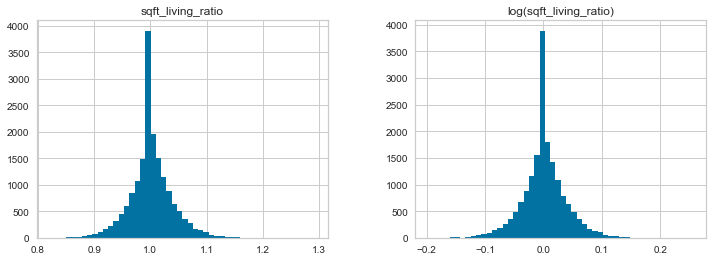

In [118]:
# Plotting histogram of this new column to check for normality 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

model_3_train.hist('sqft_living_ratio', ax = ax1, bins=50)

model_3_log = np.log(model_3_train['sqft_living_ratio'])
model_3_log.hist(ax = ax2, bins=50)

ax2.set_title('log(sqft_living_ratio)');

The data is pretty normally distributed, and symmetric, but the mean falls at 1 instead of 0. Logging the data appears to correct this problem, so I will log this feature in my model going forward. 

In [119]:
# Creating the log-transformed column
model_3_train['log_sqft_living_ratio'] = np.log(model_3_train['sqft_living_ratio'])
model_3_test['log_sqft_living_ratio'] = np.log(model_3_test['sqft_living_ratio'])

In [120]:
model_3_train.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y,sqft_living_ratio,log_sqft_living_ratio
0,12.49,0.69,0.56,7.11,9.66,0.00,1.10,6,7.59,7.32,12.28,0.97,-0.03
1,12.49,1.39,0.92,7.78,8.43,0.69,1.10,8,7.60,7.71,12.54,1.01,0.01
2,12.49,1.61,0.56,7.58,9.07,0.00,1.10,7,7.58,7.41,12.52,1.02,0.02
3,12.49,1.10,0.00,7.24,9.68,0.00,1.39,6,7.58,7.26,12.35,1.00,-0.00
4,12.49,1.39,0.56,7.49,9.39,0.00,1.61,6,7.57,7.35,12.21,1.02,0.02


In [121]:
# Drop unnecessary columns from these dataframes - we have a new logged column, so can get rid of the
# old columns relevant to square footage. 
model_3_train = model_3_train.drop(['sqft_living','sqft_living15','sqft_living_ratio'], axis =1)

In [122]:
model_3_train.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_lot,floors,condition,grade,yr_built,price_y,log_sqft_living_ratio
0,12.49,0.69,0.56,9.66,0.00,1.10,6,7.59,12.28,-0.03
1,12.49,1.39,0.92,8.43,0.69,1.10,8,7.60,12.54,0.01
2,12.49,1.61,0.56,9.07,0.00,1.10,7,7.58,12.52,0.02
3,12.49,1.10,0.00,9.68,0.00,1.39,6,7.58,12.35,-0.00
4,12.49,1.39,0.56,9.39,0.00,1.61,6,7.57,12.21,0.02


In [123]:
model_3_train.shape

(17276, 10)

In [124]:
# Do the same for testing data 
model_3_test = model_3_test.drop(['sqft_living','sqft_living15','sqft_living_ratio'], axis =1)

In [125]:
model_3_test.head()

,price_x,bedrooms,bathrooms,sqft_lot,floors,condition,grade,yr_built,price_y,log_sqft_living_ratio
0,12.49,1.10,0.56,9.21,0.00,1.39,7,7.59,12.47,0.01
1,12.49,1.10,0.00,8.78,0.41,1.39,5,7.57,12.05,0.01
2,12.49,1.10,0.69,9.81,0.00,1.39,7,7.58,12.43,-0.07
3,12.49,1.61,0.92,8.87,0.69,1.10,8,7.60,12.51,0.04
4,12.49,1.10,0.81,9.34,0.00,1.10,7,7.58,12.35,-0.03


In [126]:
# Divide data in to x predictors and y targets 
X_train_3 = model_3_train.drop(['price_y'], axis=1)
y_train_3 = model_3_train[['price_y']]

X_test_3 = model_3_test.drop(['price_y'], axis=1)
y_test_3 = model_3_test[['price_y']]

In [127]:
y_train_3.shape

(17276, 1)

In [128]:
# Train our scaler on training data, then fit to testing
X_train_3_scaled = scaler.fit_transform(X_train_3)
X_test_3_scaled = scaler.transform(X_test_3)

In [129]:
# Fit our model on our scaled data
lr.fit(X_train_3_scaled, y_train_3)

LinearRegression()

In [130]:
y_train_3_pred = lr.predict(X_train_3_scaled)
y_test_3_pred = lr.predict(X_test_3_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train_3, y_train_3_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_3, y_train_3_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test_3, y_test_3_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_3, y_test_3_pred)}")

Training Scores:
R2: 0.8023777345291427
Mean Absolute Error: 0.17654766868870625
---
Testing Scores:
R2: 0.8037440060304246
Mean Absolute Error: 0.1742813544491742


In [131]:
#Using Lindsey's function to print our errors in dollar amounts
fn.print_metrics(y_train_3, y_train_3_pred, y_test_3, y_test_3_pred, log=True)

Training Scores
----------
R2: 0.8024
RMSE: 183285.3838
MAE: 100840.3496

**********
Testing Scores
----------
R2: 0.8037
RMSE: 188501.1256
MAE: 98757.0083


Combining the square footage and square footage of nearest 15 neighbors into one ratio feature apparently does not result in a model with less error. The coefficient of determination went down slightly, while both the root mean squared error and the mean absolute error went up slightly, by about  $ 5k for the mean absolute error and about $ 8k for the root mean squared error, back up to hover around almost $100,000, which would carry significant consequences both for our stakeholder's capital and the amount that sellers receive.

However, I think accounting for this potential multicollinearity is ultimately a good thing for the integrity of our model; ultimately, we want to make sure all our independent variables are truly independent. Furthermore, combining these two columns did not ding our r-squared by *that* much. 

Therefore, I think this is overall a fairly reliable model and a good stopping point for right now. Given more time, I could address the other multicollinear relationships flagged above, and try other methods to reduce that error - for example, changing the square footage ratio to something else, or combining with Eldrich's engineered features and testing further. 

# 10. Evaluation

This time, let's check the residuals of our final model using a histogram.

In [132]:
# Note: I will use the residuals for the training dataset
residuals_mod_3 = y_train_3 - y_train_3_pred

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


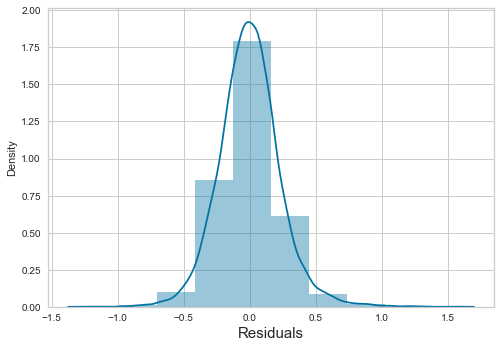

In [133]:
# Now plot the distribution of residuals
sns.distplot(residuals_mod_3, bins = 10)
plt.xlabel('Residuals', fontsize = 15)     
plt.show()

Woohoo! Residuals are more or less normally distributed and symmetrical at 0. 

## Coefficient Evaluation

In [134]:
X = X_train_3_scaled
y = y_train_3

model_3 = sm.OLS(y, sm.add_constant(X))

results_mod_3 = model_3.fit()

results_mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     7789.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        10:09:07   Log-Likelihood:                 540.57
No. Observations:               17276   AIC:                            -1061.
Df Residuals:                   17266   BIC:                            -983.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0493      0.002   7311.522      0.000      13.046      13.053
x1             0.2663      0.002    129.547      0.000       0.262       0.270
x2             0.0092      0.002      4.073      0.000       0.005       0.014
x3             0.0938      0.003     31.680      0.000       0.088       0.100
x4             0.0380      0.002     19.185      0.000       0.034       0.042
x5             0.0242      0.002     10.298      0.000       0.020       0.029
x6             0.0197      0.002     10.197      0.000       0.016       0.024
x7             0.2280      0.003     84.980      0.000       0.223       0.233
x8            -0.1111      0.002    -45.956      0.000      -0.116      -0.106
x9             0.0378      0.002     17.280      0.000       0.034       0.042
==============================================================================
Omnibus:                     1157.675   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3482.043
Skew:                           0.340   Prob(JB):                         0.00
Kurtosis:                       5.092   Cond. No.                         3.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
# printing column names again, because coefficients above are not identified by column names. 
X_train_3.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_lot,floors,condition,grade,yr_built,log_sqft_living_ratio
0,12.49,0.69,0.56,9.66,0.00,1.10,6,7.59,-0.03
1,12.49,1.39,0.92,8.43,0.69,1.10,8,7.60,0.01
2,12.49,1.61,0.56,9.07,0.00,1.10,7,7.58,0.02
3,12.49,1.10,0.00,9.68,0.00,1.39,6,7.58,-0.00
4,12.49,1.39,0.56,9.39,0.00,1.61,6,7.57,0.02


Probably most important is the fact that the constant value is much higher than any of the coefficient values. This implies that there are some factors influencing house price that are not accounted for in my model. Given more time and money, it would be worth doing some research to figure out some of other important potential predictors in the sea of infinite variables - proximity to a school, or a park, or crime rate per zip code comes to mind.

By far, median sales price for a home's zip code is the strongest predictor in this current model. Grade was the second most-powerful predictor. Going up one standard deviation with the zip code feature increased a home's price by almost 27%, while going up one standard deviation in grade can increase price by 23%. 

Also noteworthy is the fact that a home's lot size as a standalone predictor seems to affect a home sales price about  as much as the ratio of its square footage compared to that of its neighbors. This may tell us that lot size is not nearly as influential as interior square footage, as de-emphasizing the latter feature by combining the two square footage columns into one feature still resulted in a feature with equivalent influence as lot size. This also lends support to the idea that location is an important predictor, as the square footage ratio feature implicitly took location into account. 

# Conclusion, Limitations and Future Work 

As stated above, median sales price and grade were the two strongest predictors to come out of my model. 

Square footage was also initially a strong predictor, but presented some evidence of multicollinearity. My attempt at fixing this multicollinarity through combining the two square footage features into one ratioed featured resulted in a model with a decreased ability to account for variance, and greater error. 

The high error of my final model of almost $100,000 could point to a few different limitations - namely, that my model may perform poorly at predicting the sales of houses that fall within the extreme upper and lower price levels. Depending on the frequency with which OpenDoor encounters these outliers, a possible solution for this would be to create separate models for different pricing categories. 

Alternatively, I could combine my model with Eldrich's refine condition and square footage features to see if that reduces error even further. 

The large error value and the large constant hint that there are other influences on sales price that this model might be ignoring. Some ideas for future work include: 

*Feeding our model aggregated data on school quality, crime rate, or green space by zip code. These are some of the most frequent things you hear brought up when someone is discussing buying or selling a home, but was not included in the dataset. This kind of context may help reduce our error. 

*As mentioned in my zip code modeling, neighborhoods in lieu of zip codes might be a more meaningful way of framing location data, for both my model's accuracy and end-user relevance. 

*Treating my house-related features (e.g., bathrooms, bedrooms, floors) as something other than continuous variables. Instead, we could perhaps create dummy variables that group homes into categories - such as a house with multiple bathrooms vs. a single bathroom. This would require our model to have to work less hard to learn the specifics of each feature -- instead of learning the prices associated with 1,2,3,4 or 5 bathrooms, the data would be aggregated into just two groups (single or multi-bathroom). This would perhaps help mitigate our overfitting. 